In [23]:
import polars as pl
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV

from sklearn.metrics import RocCurveDisplay, confusion_matrix, classification_report, precision_score, recall_score, f1_score


import sys
import joblib
import pickle

import warnings
warnings.filterwarnings("ignore")


# Predicting heart disease using ML

We will use ML(classification) to predict wether someone has heart disease or not .

Our approach:
1. Problem definition
2. Data
3. Evaluation
4. Features
5. Modeling
6. Experimentation


## 1. Problem Definition
> Given clinical parameters about a patient, can we predict whether or not they have a heart disease?


## 2. Data
UCI heart disease dataset (from Kaggle).
* Url: 
https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset


## 3. Evaluation
> If we can reach 95% accuracy with our prediction during the proof of concept, we'll pursue the project.

## 4. Features


1. age - age in years 
2. sex - (1 = male; 0 = female) 
3. cp - chest pain type 
    * 0: Typical angina: chest pain related decrease blood supply to the heart
    * 1: Atypical angina: chest pain not related to heart
    * 2: Non-anginal pain: typically esophageal spasms (non heart related)
    * 3: Asymptomatic: chest pain not showing signs of disease
4. trestbps - resting blood pressure (in mm Hg on admission to the hospital)
    * anything above 130-140 is typically cause for concern
5. chol - serum cholestoral in mg/dl 
    * serum = LDL + HDL + .2 * triglycerides
    * above 200 is cause for concern
6. fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false) 
    * '>126' mg/dL signals diabetes
7. restecg - resting electrocardiographic results
    * 0: Nothing to note
    * 1: ST-T Wave abnormality
        - can range from mild symptoms to severe problems
        - signals non-normal heart beat
    * 2: Possible or definite left ventricular hypertrophy
        - Enlarged heart's main pumping chamber
8. thalach - maximum heart rate achieved 
9. exang - exercise induced angina (1 = yes; 0 = no) 
10. oldpeak - ST depression induced by exercise relative to rest 
    * looks at stress of heart during excercise
    * unhealthy heart will stress more
11. slope - the slope of the peak exercise ST segment
    * 0: Upsloping: better heart rate with excercise (uncommon)
    * 1: Flatsloping: minimal change (typical healthy heart)
    * 2: Downslopins: signs of unhealthy heart
12. ca - number of major vessels (0-3) colored by flourosopy 
    * colored vessel means the doctor can see the blood passing through
    * the more blood movement the better (no clots)
13. thal - thalium stress result
    * 1,3: normal
    * 6: fixed defect: used to be defect but ok now
    * 7: reversable defect: no proper blood movement when excercising 
14. target - have disease or not (1=yes, 0=no) (= the predicted attribute)


## Load data

In [24]:
df = pd.read_csv('./data/heart-disease.csv')
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


## Data Exploration (exploratory data analysis EDA)


In [25]:
# checking the balance of the data (target)
df.target.value_counts()

1    165
0    138
Name: target, dtype: int64

<Axes: >

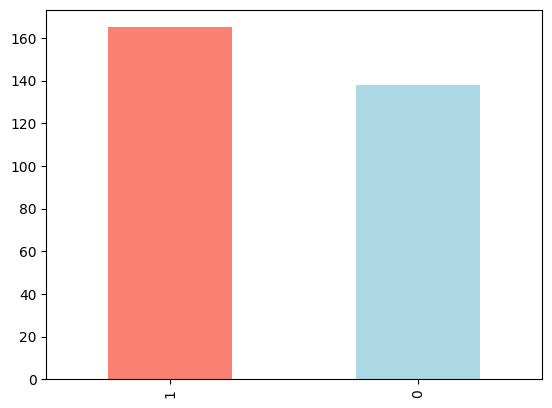

In [26]:
df.target.value_counts().plot(kind='bar', color=['salmon', 'lightblue'])

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [28]:
# checking if there is missing data
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [29]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


### Heart disease frequency according to `Sex`

In [30]:
df.sex.value_counts()

1    207
0     96
Name: sex, dtype: int64

In [31]:
# Compare `target` column to `sex` column
pd.crosstab(df.target, df.sex)

sex,0,1
target,,
0,24,114
1,72,93


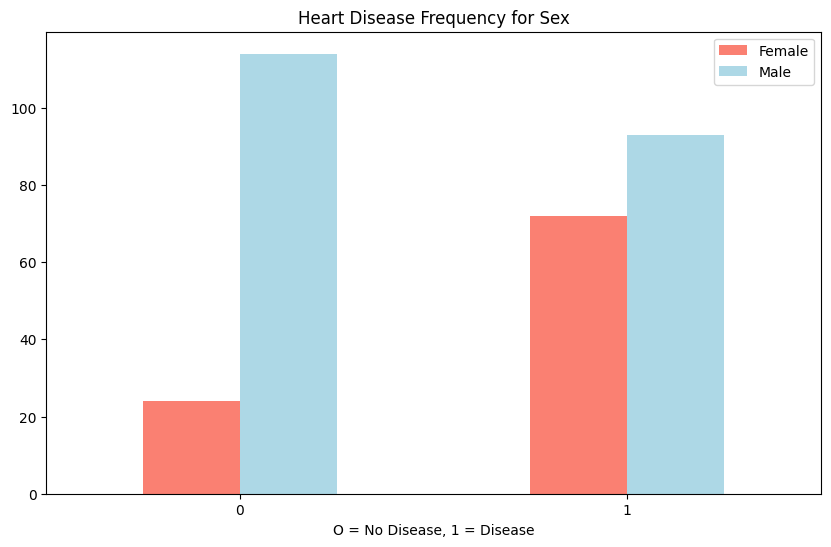

In [32]:
pd.crosstab(df.target, df.sex).plot(kind='bar',
                                    figsize=(10,6),
                                    color=['salmon', 'lightblue']);
plt.title('Heart Disease Frequency for Sex')
plt.xlabel('O = No Disease, 1 = Disease')
plt.legend(['Female', 'Male'])
plt.xticks(rotation=0);

### `age` vs `thalach` for Heart disease 

In [33]:
df.thalach.value_counts()

162    11
160     9
163     9
152     8
173     8
       ..
202     1
184     1
121     1
192     1
90      1
Name: thalach, Length: 91, dtype: int64

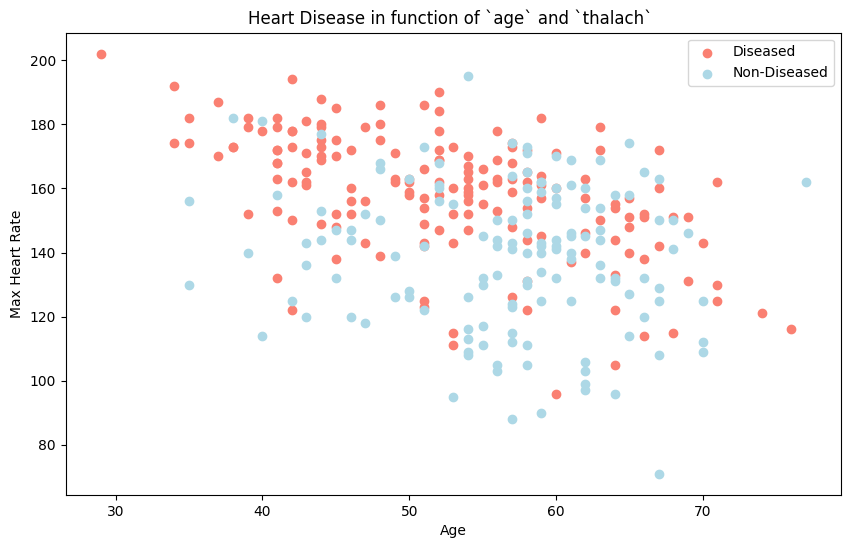

In [34]:
plt.figure(figsize=(10,6))

# positive examples
plt.scatter(df.age[df.target==1],
            df.thalach[df.target==1],
            c='salmon')

# negative example
plt.scatter(df.age[df.target==0],
            df.thalach[df.target==0],
            c='lightblue')

# Info
plt.title('Heart Disease in function of `age` and `thalach` ')
plt.xlabel('Age')
plt.ylabel('Max Heart Rate')
plt.legend(['Diseased', 'Non-Diseased']);

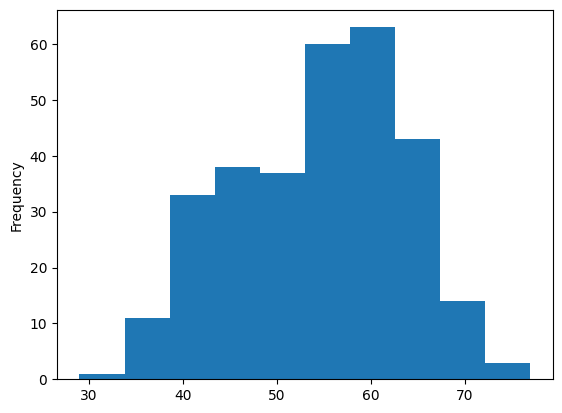

In [35]:
# Distribution of age 
df.age.plot.hist();

### Chest pain `cp` against `target`

In [36]:
pd.crosstab(df.cp, df.target)
# Reminder : 1 = heart disease | 0 = NOT

target,0,1
cp,,
0,104,39
1,9,41
2,18,69
3,7,16


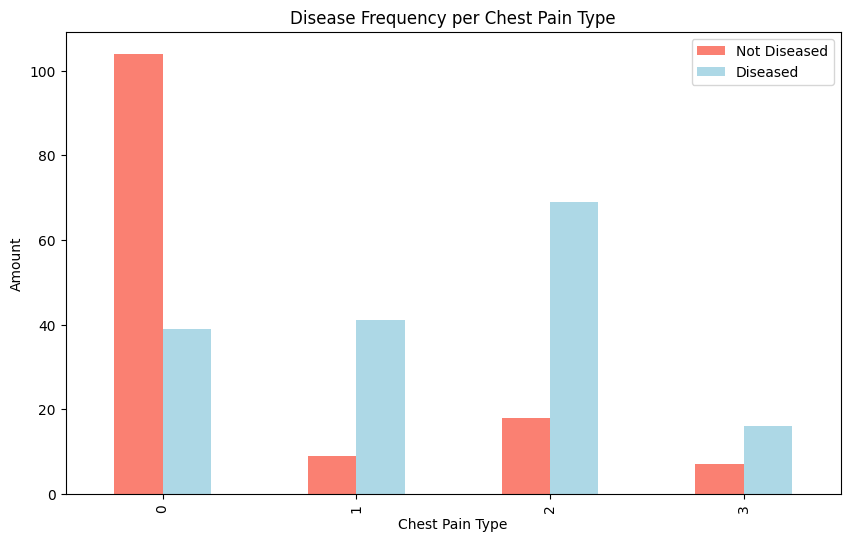

In [37]:
pd.crosstab(df.cp, df.target).plot(kind='bar',
                                   figsize=(10, 6),
                                   color=['salmon','lightblue'])
plt.title('Disease Frequency per Chest Pain Type')
plt.xlabel('Chest Pain Type')
plt.ylabel('Amount')
plt.legend(['Not Diseased', 'Diseased']);

In [38]:
# Correlation matrix
df.corr() 
#* higher positive value means potential positive correlation and opposite for negative

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trestbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalach,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exang,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


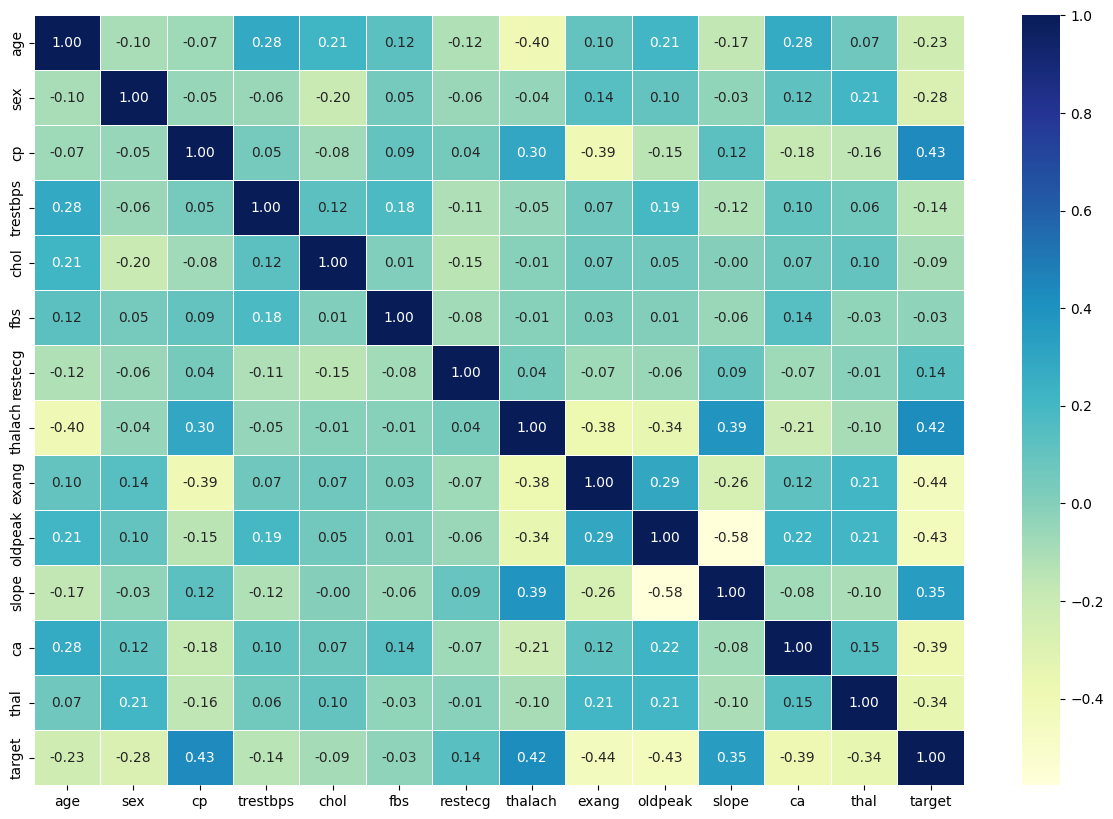

In [39]:
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize= (15,10))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt='.2f',
                 cmap='YlGnBu'
                 )

#in case the fig isn't displaying well, uncomment the following:
#bottom, top = ax.get_ylim()
#ax.set_ylim(bottom+0.5, top -0.5)

## 5. Modeling

In [40]:
# seed
np.random.seed(42)

# Split data into X/y 
X = df.drop('target', axis=1)
y= df['target']

# Split into train & test set
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2)

# Models
models= {'KNN': KNeighborsClassifier(),
         'RandomForestClassifier': RandomForestClassifier(),
         'Logistic Regression': LogisticRegression()    
         }

def fit_n_train(models, X_train, y_train, X_test,y_test):
    
    model_scores ={}
    
    for name, model in models.items():
        # Fit the model
        model.fit(X_train, y_train)
        # Evaluate the model
        model_scores[name] = model.score(X_test, y_test)
    return model_scores



In [41]:
model_scores=fit_n_train(models=models,
                         X_train=X_train,
                         y_train=y_train,
                         X_test=X_test,
                         y_test=y_test)

In [42]:
model_scores

{'KNN': 0.6885245901639344,
 'RandomForestClassifier': 0.8524590163934426,
 'Logistic Regression': 0.8852459016393442}

### Model Comparison

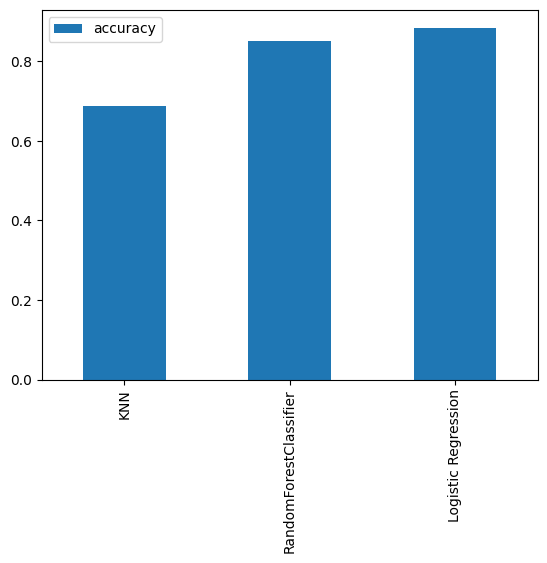

In [43]:
model_compare = pd.DataFrame(model_scores, index=['accuracy'])
model_compare.T.plot.bar();